In [1]:
import os
import glob
import warnings
import itertools

import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd

from github import Github
from matplotlib import pyplot, cm, colors, dates, rcParams, ticker
from matplotlib.colors import LogNorm, PowerNorm
from matplotlib.ticker import AutoLocator

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
def stylize_ax(ax):
    if type(ax) == np.ndarray:
        [stylize_ax(_) for _ in ax]
        return
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    
    legend = ax.get_legend()
    ax.legend(
        loc='upper left',
        title=legend.get_title().get_text() if legend else None
    )

In [3]:
muni = pd.read_csv('../update/sdsn.gen.csv')
muni = muni.set_index('cod_ine')

cmun = muni[['municipio']]
cmun = cmun[~cmun.index.duplicated(keep='first')]

In [4]:
cmun_idx = [int(_ * 1e4 + 101) for _ in range(1, 10)]
cmun.loc[cmun_idx] = cmun.loc[cmun_idx].applymap(lambda _: '*** ' + _)

In [5]:
bolivia_map = gpd.read_file('../update/municipio_geo.geojson')
bolivia_map_dept = bolivia_map.dissolve('DEPARTAMEN')

In [6]:
COLOR_MAP = {
    2: 0,
    3: 1,
    7: 2,
    4: 3,
    5: 4,
    6: 5,
    1: 6,
    8: 7,
    9: 8
}
NAME_MAP = {
    (_ + 1):__ for _, __ in enumerate(muni['departamento'].unique())
}
PALETTE = pd.Series(sns.color_palette('tab10'))

def draw(X, Xf, title=None, title_secondary=None, norm=None, figsize=None, **kwargs):
    if norm is None:
        norm = PowerNorm(gamma=.2)
        
    if figsize is None:
        figsize=(30 / 2.54, 30 / 2.54)

    fig = pyplot.figure(figsize=figsize, facecolor='white')
    gs = fig.add_gridspec(len(X) + 23, 50)
    
    curve_ax = fig.add_subplot(gs[:22, 1:-5])
    
    order = pd.Series([2, 4, 5, 3, 1, 6, 9, 8, 7])
    X_acc = X.groupby(lambda _: int(_ / 1e4)).sum().round().T[order]
    X_acc.columns = X_acc.columns.map(NAME_MAP)
    
    X_acc.plot.area(
        color=PALETTE[order.map(COLOR_MAP)],
        alpha=.85,
        ax=curve_ax
    )
    
    curve_ax.axis('off')
    curve_ax.grid(color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    curve_ax.legend(loc='upper left')
    curve_ax.set_xlim( X_acc.index.min(), X_acc.index.max())

    
    curve_ax.set_title(title, fontsize=32)
    
    map_ax = fig.add_subplot(gs[:22, -5:])
    
    bolivia_map_dept.plot(
        color=PALETTE[
            (bolivia_map_dept['c_ut'].astype(int) / 1e4).astype(int).map(COLOR_MAP)
        ], 
        alpha=.9,
        ax=map_ax
    )

    map_ax.axis('off')

    matrix_base = (X.index / 1e4).astype(int).map(COLOR_MAP)
    color_to_value = dict((col, i) for i, col in enumerate(PALETTE))

    matrix = np.array([
        color_to_value[c] for c in PALETTE
    ])
    matrix = matrix.reshape((1, len(PALETTE)))
    matrix = matrix[:, matrix_base].T
    matrix = pd.DataFrame(matrix)
    matrix.index = [_ for _ in itertools.chain(*cmun.loc[X.index].to_numpy())]
    
    cmap = colors.ListedColormap(PALETTE[:-1])
    
    crow_ax = fig.add_subplot(gs[23:, 0])
    sns.heatmap(
        matrix, vmin=0, vmax=8,
        cmap=cmap, 
        cbar=False, 
        ax=crow_ax,
        xticklabels=False,
        alpha=.9
    )

    Xs = (X.T / X.max(axis=1)).T.copy()
    
    main_ax = fig.add_subplot(gs[23:, 1:-5])
    im = sns.heatmap(
        Xs,
        cmap='Spectral_r', cbar=False, alpha=.85, yticklabels=False,
        norm=norm, vmax=Xs.max().max(), ax=main_ax
    )
    
    xticks = main_ax.get_xticks()
    xticks = np.arange(0.5, xticks[-1], 30)
    
    main_ax.set_xticks(xticks)
    main_ax.set_xticklabels([
        column.date() for column in Xs.iloc[:, xticks].columns
    ], rotation=0, fontsize=14)

    main_ax.axes.yaxis.set_visible(False)
    
    Xf = Xf.iloc[::-1]
    
    for idx in range(len(X)):
        row = Xf.iloc[idx:idx + 1]
        
        ax = fig.add_subplot(gs[23 + idx, -5:])
        ax = row.plot.barh(
            ax=ax, 
            stacked=True, 
            legend=False, 
            width=1.0
        )
        
        ax.set_xlim((0, Xf.sum(axis=1).max()))
        ax.axis('off')
        
        if idx == 0 and title_secondary is not None:
            ax.set_title(title_secondary)
        
    ax.axis('on')
    ax.tick_params(
        axis='y',
        labelleft=False,
        left=False
    )
    ax.set_ylabel('')
    
    for frame_border in ['top', 'right', 'left']:
        ax.spines[frame_border].set_visible(False)
    
    return main_ax

In [7]:
git = Github()
repo = git.get_repo('mauforonda/covid19bolivia-municipal')

In [8]:
df = pd.DataFrame([])
tdf = pd.DataFrame([])
dept_paths = [_ for _ in repo.get_contents('') if _.path.endswith('.csv')]

for file_name in dept_paths:
    dept_data = pd.read_csv(file_name.download_url)
    dept_data['fecha'] = pd.to_datetime(dept_data['fecha'])

    dept_data = dept_data.set_index(['cod_ine', 'fecha'])['confirmados'].unstack()
    tdf = pd.concat([tdf, dept_data])

    dept_data = dept_data.fillna(0).T
    dept_data = dept_data.rolling(window=14).sum().dropna(how='all').T.round()
    
    df = pd.concat([df, dept_data])

In [9]:
fdata = df
fdata = fdata[fdata.T.max() > 15]
fdata = fdata.T.interpolate(method='linear').T
fdata = fdata.fillna(0).round()
fdata[fdata < 1] = 1e-3

fdata = fdata.loc[fdata.idxmax(axis=1).sort_values(ascending=False).index]

In [10]:
def do_dumb_sort(matrix):
    matrix = matrix.copy()
    
    for idx in range(2, len(matrix) - 2):
        el = matrix.iloc[idx][0]
        if el == matrix.iloc[idx - 2][0] and el != matrix.iloc[idx - 1][0]:
            swap_with = idx - 1
        elif el == matrix.iloc[idx + 2][0] and el != matrix.iloc[idx + 1][0]:
            swap_with = idx + 1
        else:
            continue

        matrix_index = matrix.index.to_numpy().copy()
        matrix_index[idx], matrix_index[swap_with] = matrix_index[swap_with], matrix_index[idx]

        matrix = matrix.loc[matrix_index]
        
    return matrix

def dumb_sort(matrix, it=3):
    for _ in range(it):
        matrix = do_dumb_sort(matrix)
        
    return matrix

In [11]:
fdata_index = pd.DataFrame((fdata.index / 1e4).astype(int), fdata.index)
fdata_index = fdata_index.rename({'cod_ine': 0}, axis=1)

fdata_index = dumb_sort(fdata_index)

In [12]:
fdata = fdata.loc[fdata_index.index]

In [13]:
pdata = (1e5 * tdf.loc[fdata.index].sum(axis=1).div(muni['poblacion']))
pdata = pdata[~pdata.isnull()]
pdata = pdata[fdata.index]

In [14]:
SECOND = pd.to_datetime('2020-11-13')
THIRD = pd.to_datetime('2021-03-15')

pdata = 1e5 * tdf.loc[fdata.index].groupby(
    lambda _: (
        '2020-03-31' if _ < SECOND else
        '2020-11-13' if (_ >= SECOND and _ < THIRD) else
        '2021-03-13'
    ), 
    axis=1
).sum().div(muni['poblacion'], axis=0)
pdata = pdata[~pdata.isnull()]
pdata = pdata.loc[fdata.index]

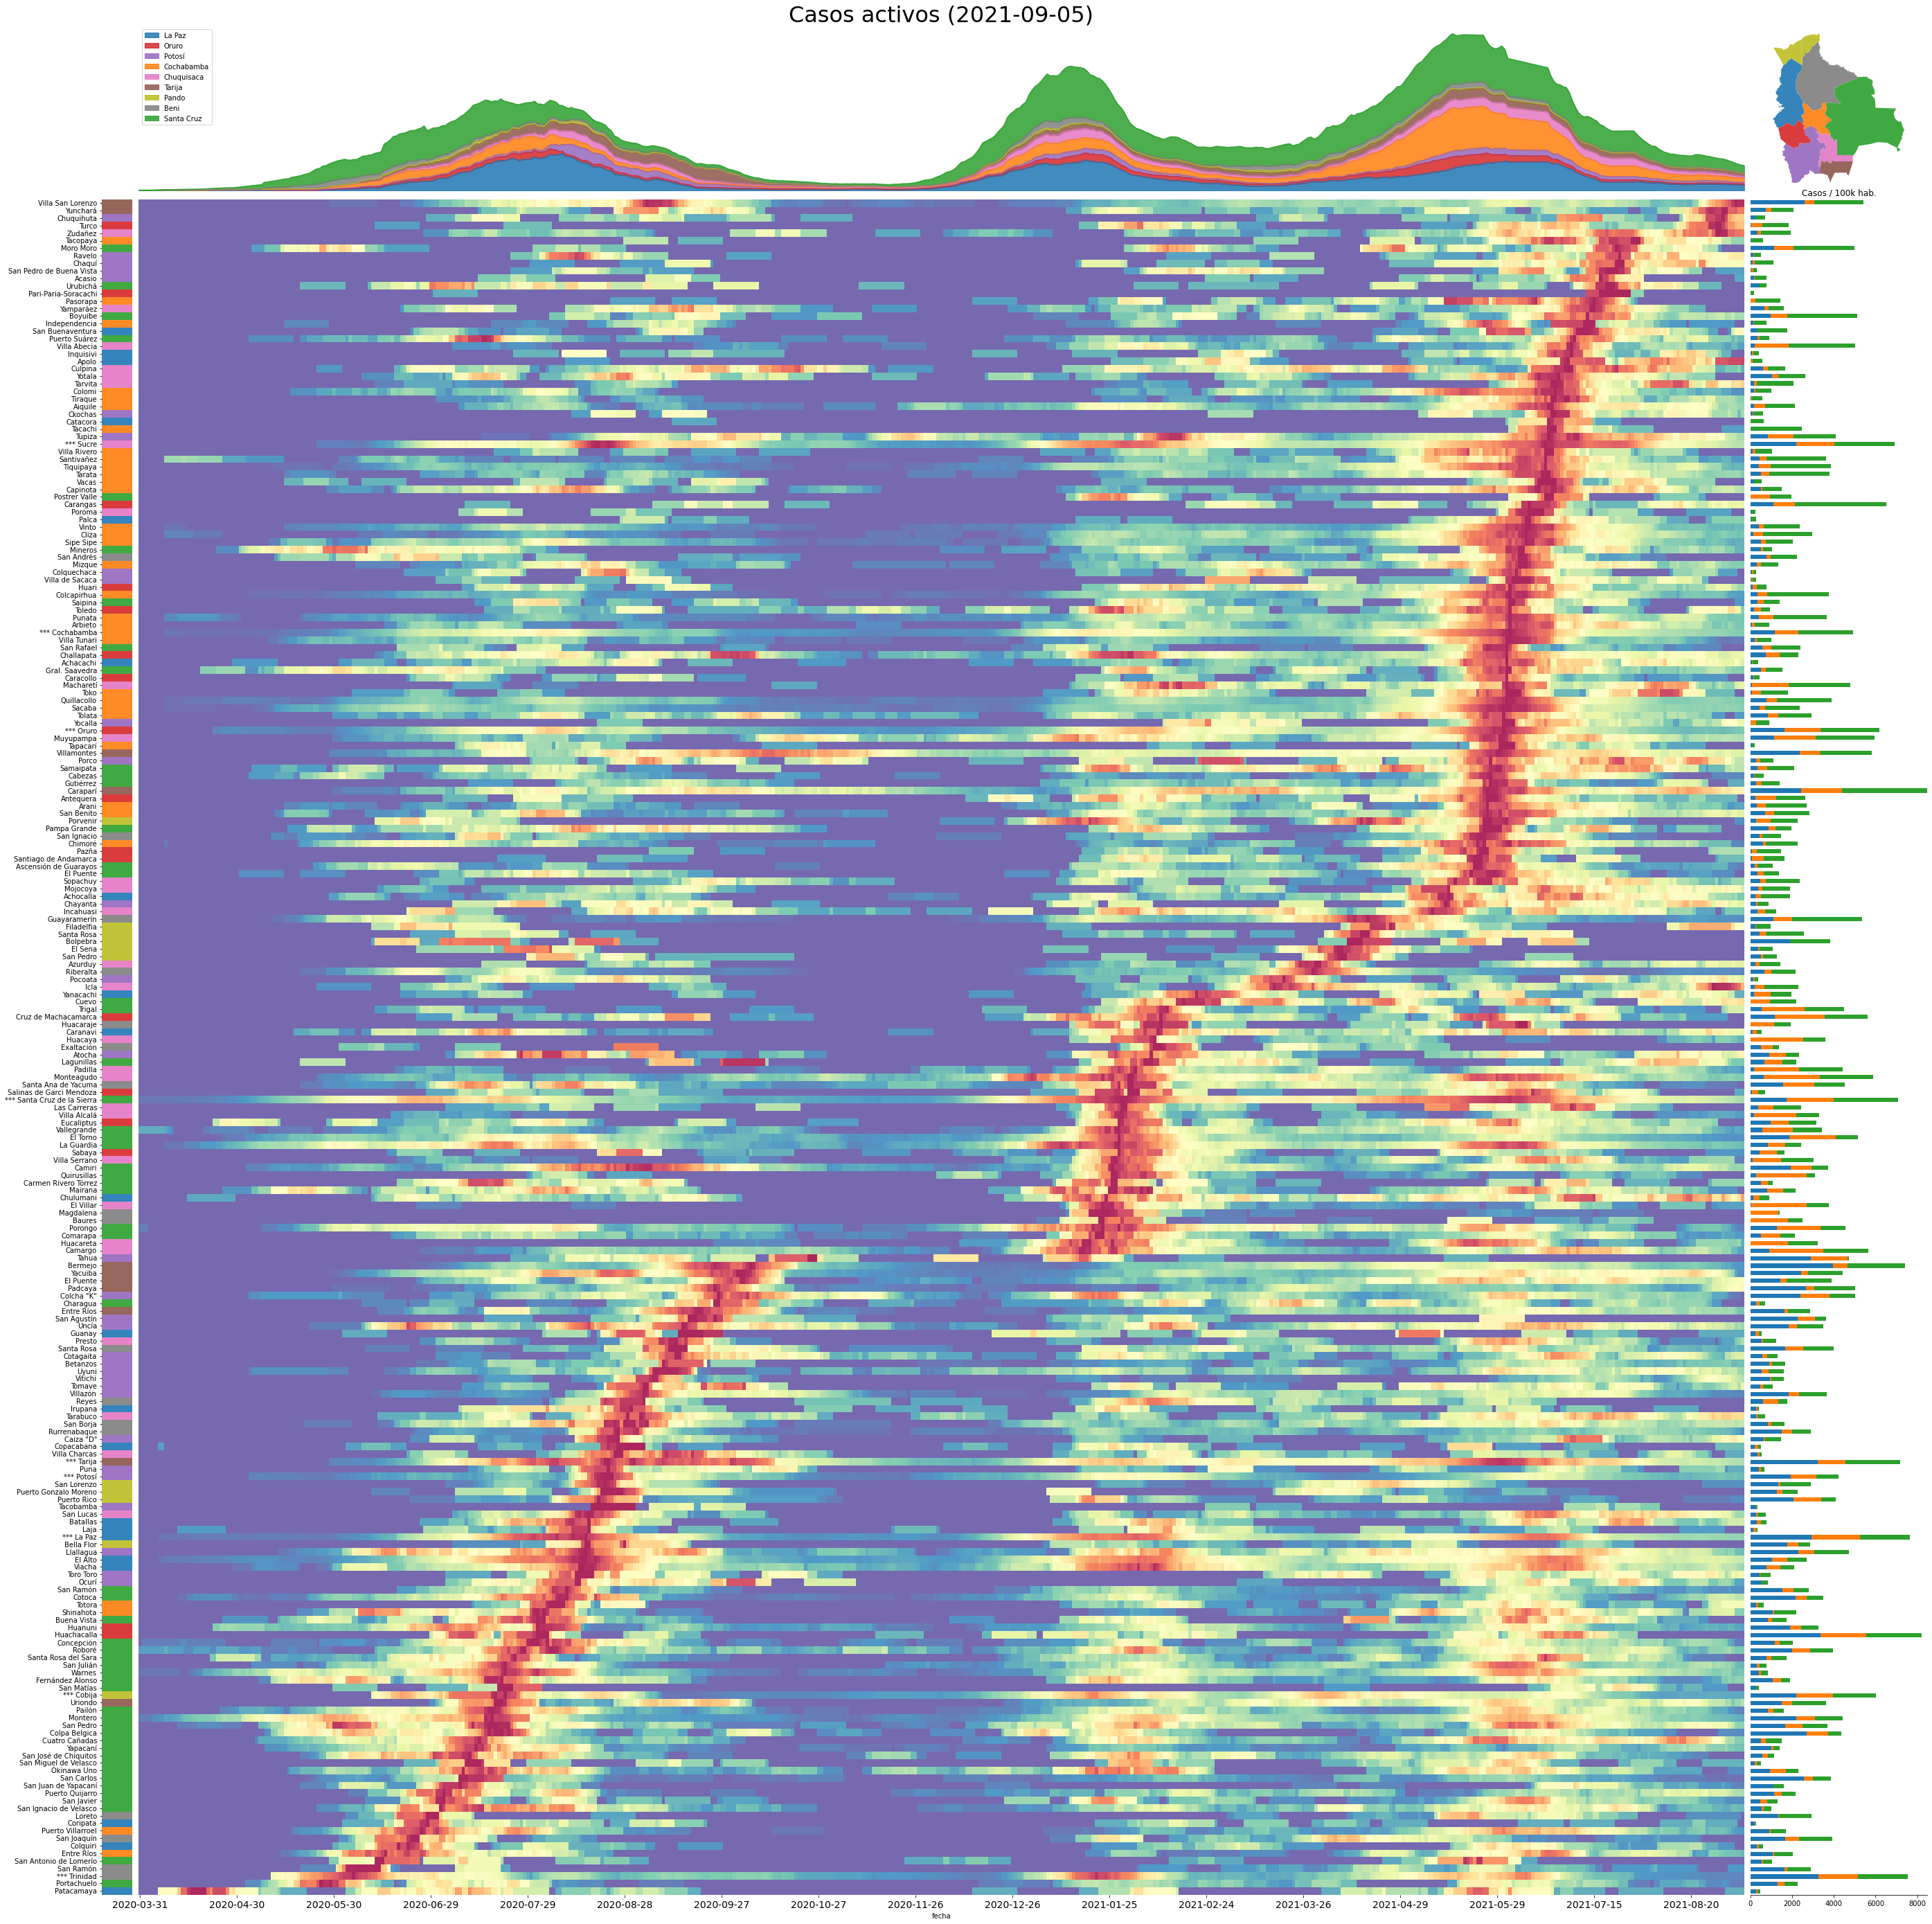

In [15]:
ax = draw(
    fdata, 
    pdata[::-1],
    title='Casos activos ({})'.format(str(fdata.columns[-1])[:10]),
    title_secondary='Casos / 100k hab.',
    norm=PowerNorm(.66),
    figsize=(120 / 2.54, 140 / 2.54)
)
ax.get_figure().savefig(
    '../img/casos.bolivia.heatmap.jpg', 
    bbox_inches='tight'
)

In [16]:
def stylize_ax(ax):
    if type(ax) == np.ndarray:
        [stylize_ax(_) for _ in ax]
        return
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    ax.legend(
        loc='upper left',
    )


No handles with labels found to put in legend.


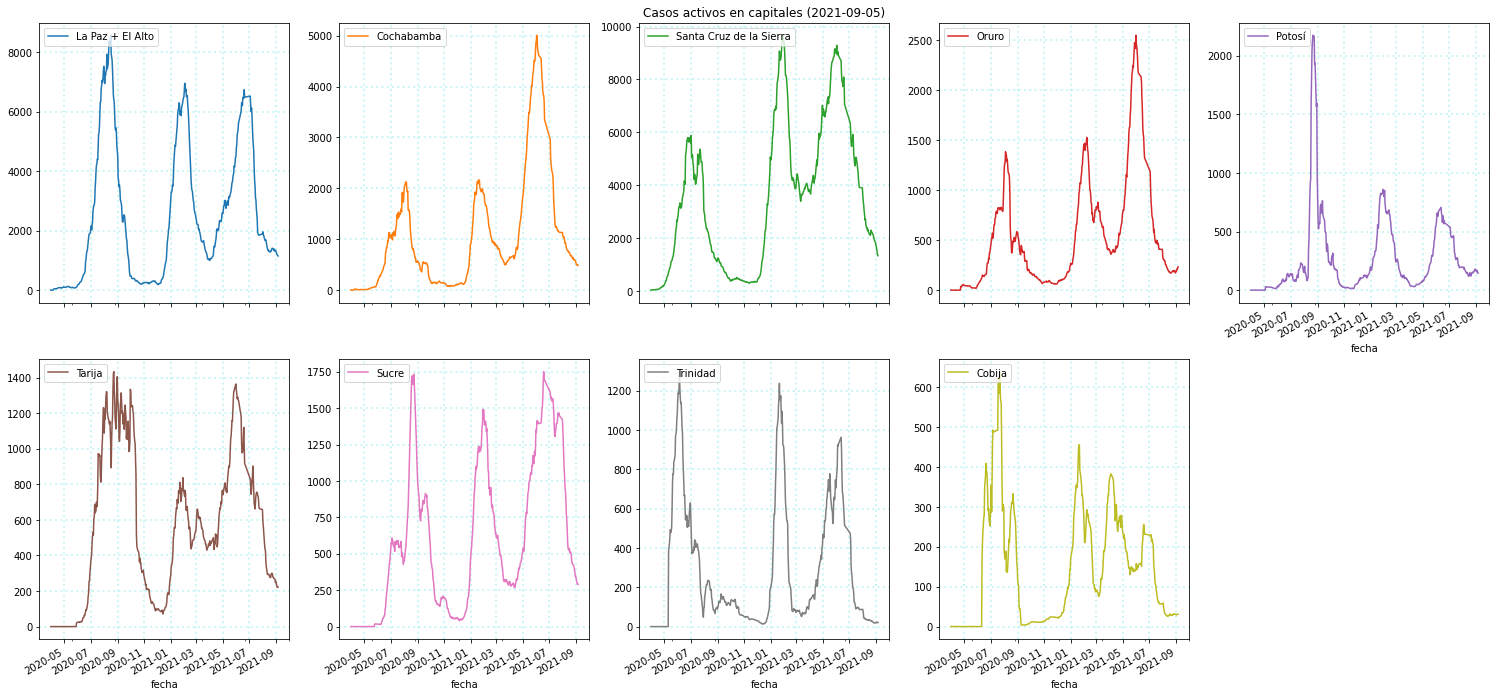

In [17]:
CAPITALS = [20101, 20105, 30101, 70101, 40101, 50101, 60101, 10101, 80101, 90101]

capital_fdata = fdata.loc[CAPITALS].T
capital_fdata.columns = cmun.loc[capital_fdata.columns]['municipio'].str.replace('\*\*\* ', '')
capital_fdata['La Paz + El Alto'] = capital_fdata['La Paz'] + capital_fdata['El Alto']

capital_muni = muni.loc[CAPITALS]['poblacion']
capital_muni.index = cmun.loc[capital_muni.index]['municipio'].str.replace('\*\*\* ', '')
capital_muni['La Paz + El Alto'] = capital_muni['La Paz'] + capital_muni['El Alto']

capital_fdata = capital_fdata[np.roll(capital_fdata.columns[2:], 1)]

axs = capital_fdata.plot(
    subplots=True, 
    figsize=(66/2.54, 32/2.54), 
    layout=(2, 5),
#     sharey=True
)
stylize_ax(axs)
axs[0][2].set_title('Casos activos en capitales ({})'.format(str(fdata.columns[-1])[:10]))
axs[0][2].get_figure().savefig(
    '../img/casos.bolivia.capitales.jpg',
    bbox_inches='tight'
)

No handles with labels found to put in legend.


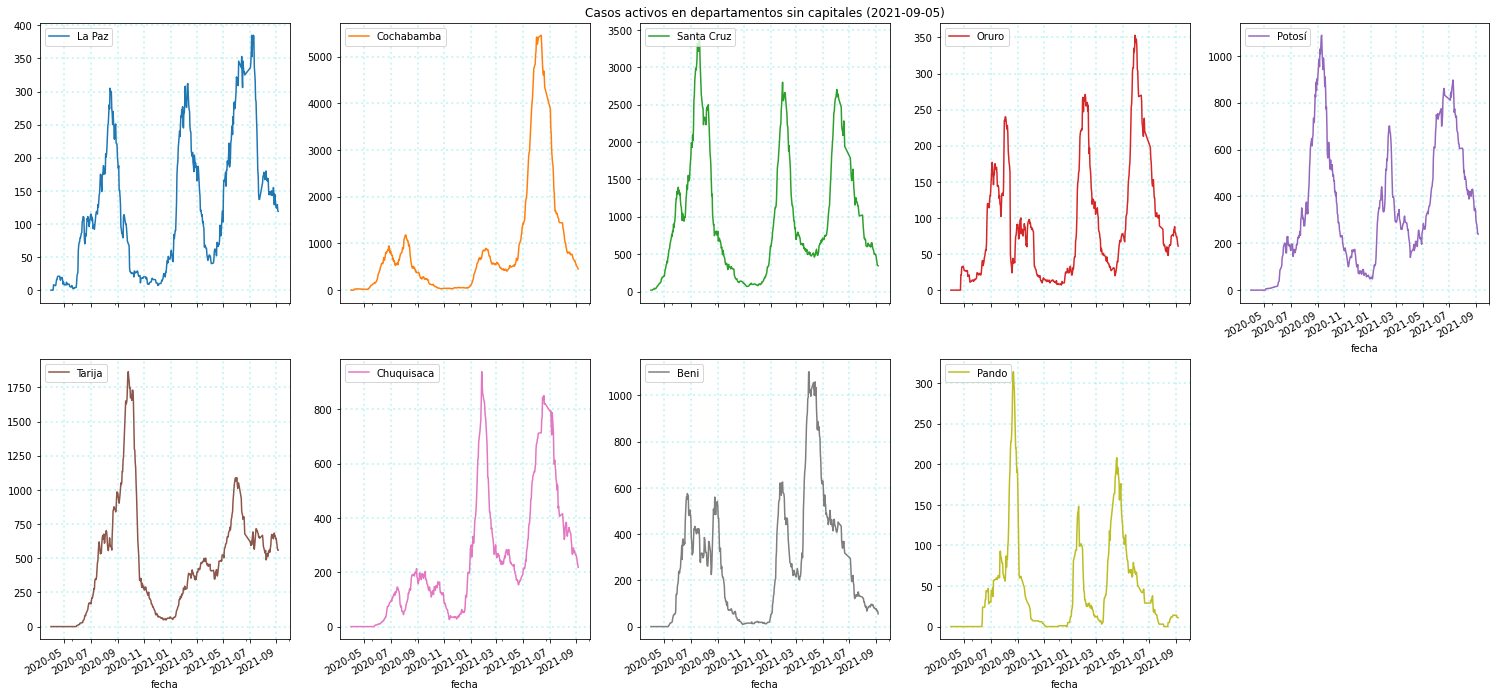

In [18]:
ORDER_2 = [
    'La Paz', 
    'Cochabamba', 
    'Santa Cruz', 
    'Oruro', 
    'Potosí',
    'Tarija',
    'Chuquisaca', 
    'Beni', 
    'Pando'
]

noncapital_fdata = fdata.loc[fdata.index[~fdata.index.isin(CAPITALS)]]
noncapital_muni = muni.loc[noncapital_fdata.index]['poblacion']

noncapital_fdata = noncapital_fdata.groupby(lambda _: str(_)[0]).sum().T
noncapital_muni = noncapital_muni.groupby(lambda _: str(_)[0]).sum().T

noncapital_fdata.columns = ['Chuquisaca', 'La Paz', 'Cochabamba', 'Oruro', 'Potosí', 'Tarija', 'Santa Cruz', 'Beni', 'Pando']
axs = noncapital_fdata[ORDER_2].plot(
    subplots=True, 
    figsize=(66/2.54, 32/2.54), 
    layout=(2, 5),
)
stylize_ax(axs)
axs[0][2].set_title(
    'Casos activos en departamentos sin capitales ({})'.format(str(fdata.columns[-1])[:10])
)

axs[0][2].get_figure().savefig(
    '../img/casos.bolivia.departamentos.sin.capitales.jpg', 
    bbox_inches='tight'
)

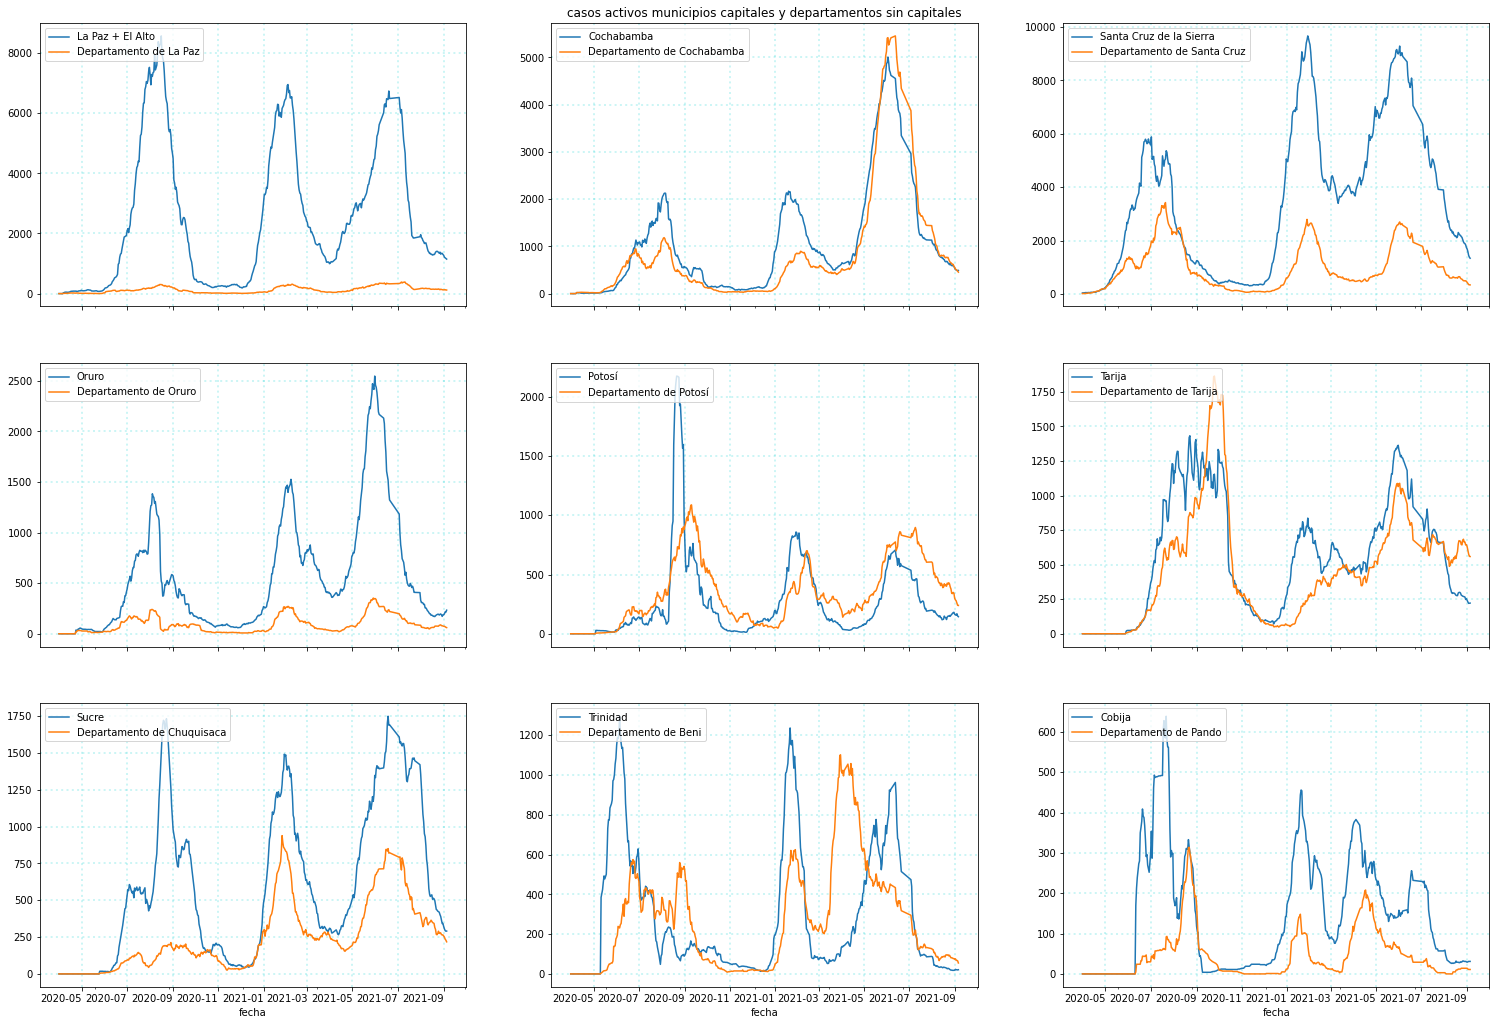

In [19]:
colors = rcParams['axes.prop_cycle'].by_key()['color']

axs = capital_fdata.plot(
    subplots=True, 
    figsize=(66/2.54, 50/2.54), 
    layout=(3, 3),
    color=colors[0],
)

axs_2 = noncapital_fdata[ORDER_2].rename(
    {_:'Departamento de {}'.format(_) for _ in noncapital_fdata.columns}, axis=1
).plot(
    subplots=True, ax=axs,#[_.twinx() for _ in axs.flatten()],
    color=colors[1]
)

axs[0][1].set_title('casos activos municipios capitales y departamentos sin capitales')
stylize_ax(axs)

axs[0][0].get_figure().savefig(
    '/tmp/casos.bolivia.comp.jpg',
    bbox_inches='tight'
)